In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


In [2]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

In [3]:
from src import *

In [4]:
db = database_loader.DatabaseLoader(get_config('connection_string'))
DEBUG = False
SCHEMA = 'controls'

file_name = "ml_stats_dataset"
data_directory = get_config('data_directory')

input_path = os.path.join(data_directory,  f"{file_name}.parquet")
assert  os.path.exists(input_path)


In [5]:
stats_df = pd.read_parquet(input_path)
stats_df.head()

,season,week,spread,rush_attempts,rush_touchdowns,pass_touchdowns,interceptions,fumble,own_kickoff_recovery,safety,...,passing_air_yards,passing_yards_after_catch,avg_dakota,carries,rushing_yards,receptions,targets,receiving_yards,receiving_air_yards,receiving_yards_after_catch
index,,,,,,,,,,,,,,,,,,,,,
0,2022,1,-23,0,1,2,0,6,0,0,...,267.0,115.0,0.007858,22.0,103.0,24.0,36.0,205.0,266.0,115.0
1,2022,3,-8,3,0,0,0,2,0,0,...,356.0,166.0,-0.000555,21.0,70.0,37.0,55.0,314.0,332.0,166.0
2,2022,4,10,5,0,2,1,3,0,0,...,180.0,87.0,0.011065,37.0,132.0,23.0,31.0,207.0,182.0,87.0
3,2022,6,-10,5,0,0,1,4,0,0,...,333.0,114.0,0.003919,28.0,144.0,23.0,36.0,222.0,340.0,114.0
4,2022,7,8,2,1,1,0,2,0,0,...,216.0,94.0,0.013561,29.0,137.0,20.0,29.0,204.0,216.0,94.0


In [6]:
stats_df['win'] = np.where(stats_df['spread'] > 0, 1, 0)
stats_df.drop(columns=['spread'], inplace=True)

In [7]:
dtype_mapping = {col: 'float' for col in stats_df.select_dtypes(include='int64')}
stats_df = stats_df.astype(dtype_mapping)

In [8]:
assert 0 == stats_df.isnull().sum().sum()

In [9]:
from typing import Set, Any


def correlate_to_target(df: pd.DataFrame, target_column: str, top_n: int) -> (pd.DataFrame, Set):

    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Filter and sort correlation coefficients by absolute value
    corr_df = pd.DataFrame(correlation_matrix.abs().unstack().sort_values(ascending=False))
    corr_df.reset_index(inplace=True)
    corr_df.columns = ['x', 'y', 'corr']

    not_self_correlated = (corr_df.y != target_column)
    win_correlated = (corr_df.x == target_column)

    df = corr_df.loc[ win_correlated & not_self_correlated ]\
        .sort_values(by='corr', ascending=False)\
        .drop(columns=['x'])\
        .head(top_n)\
        .copy()

    s = set(df['y'].values)

    return df, s


def calc_feature_importance(X: pd.DataFrame, y: pd.Series, top_n=30) -> (pd.DataFrame, Set):
    # Create an XGBoost model
    model = xgb.XGBRegressor()

    # Fit the model
    model.fit(X, y)

    # Get feature importance scores
    importance_scores = model.feature_importances_

    # Sort feature importance scores
    sorted_indices = importance_scores.argsort()[::-1]
    sorted_scores = importance_scores[sorted_indices]
    feature_names = X.columns[sorted_indices]

    # Get the top 'n' feature importance scores and names
    top_scores = sorted_scores[:top_n]
    top_features = feature_names[:top_n]
    df = pd.DataFrame({'y': top_features, 'corr': top_scores})

    set_xg_cols = set(top_features)
    return df, set(top_features)


def plot_correlations(scores: Any, features: Any, title: str):

    # Plot feature importance
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(scores)), scores, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Score')
    plt.ylabel('Column')
    plt.title(title)
    plt.show()




In [10]:
top_correlations, set_correlations = correlate_to_target(stats_df, 'win', 30)

In [11]:
import numpy as np


X = stats_df.drop(columns=['win']).copy()
y = stats_df['win']

print(X.shape)
print(y.shape)
y.value_counts()

(3569, 62)
(3569,)


1.0    2064
0.0    1505
Name: win, dtype: int64

In [12]:
top_features, set_features = calc_feature_importance(X, y, top_n=30)


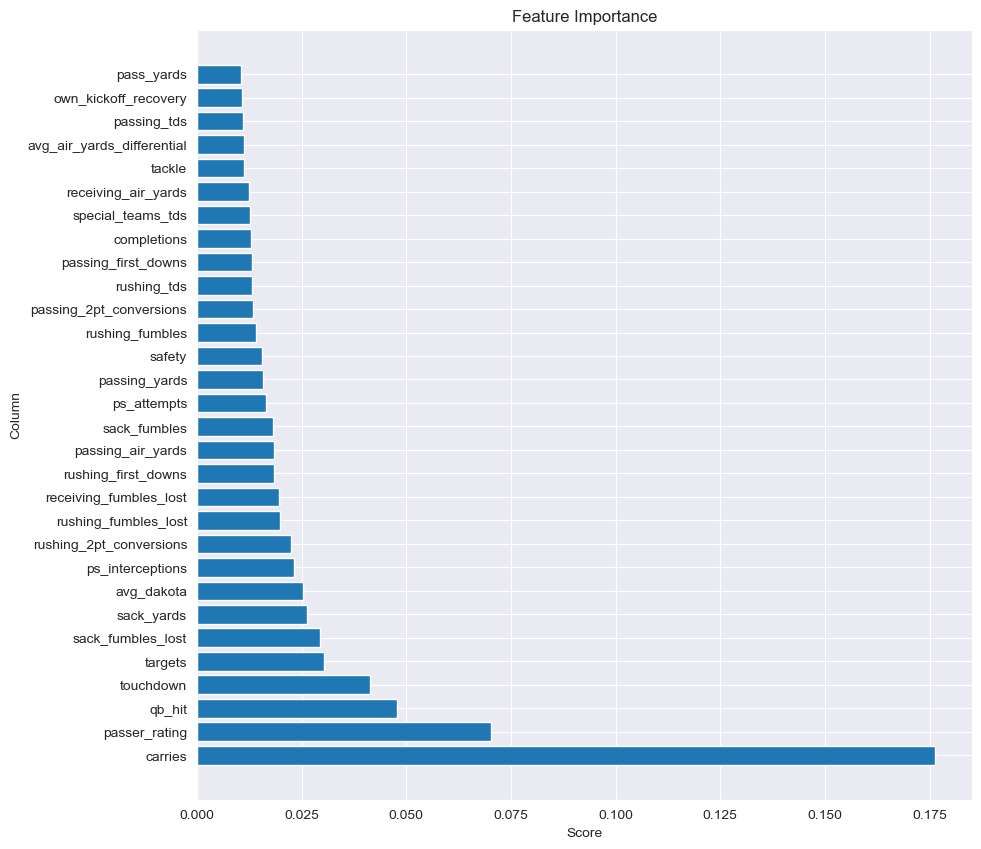

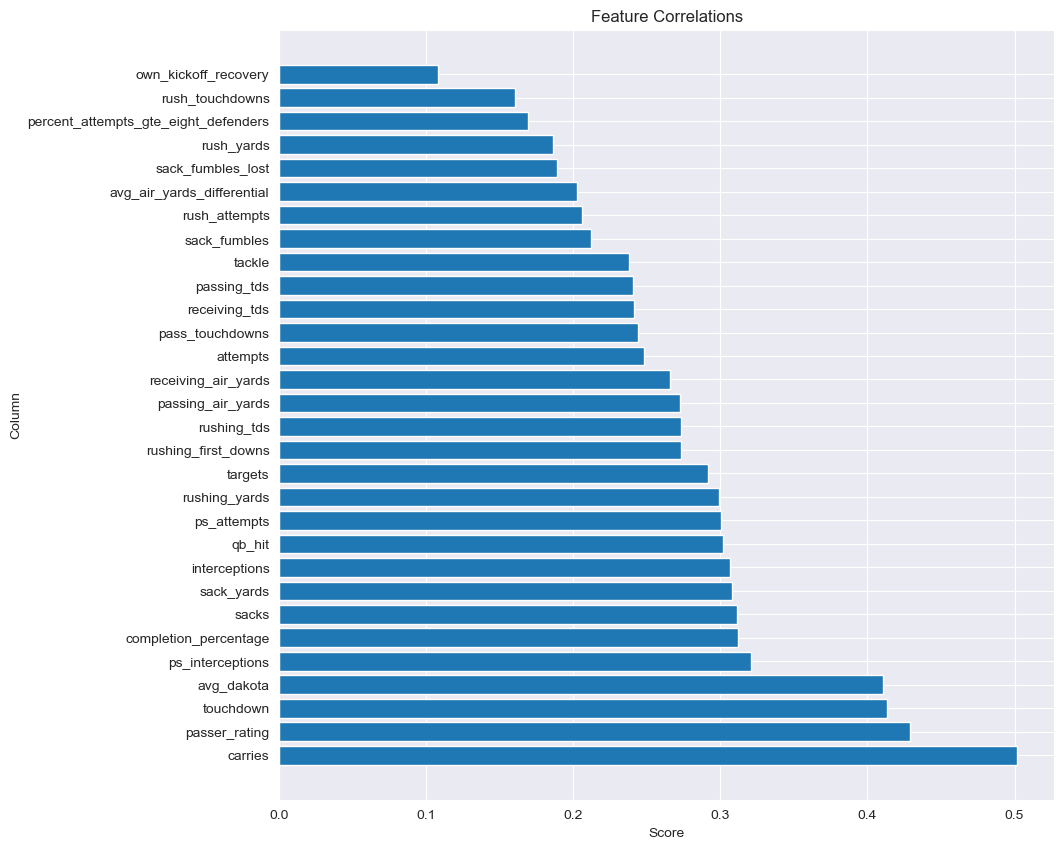

In [13]:
plot_correlations(top_features['corr'], top_features['y'], "Feature Importance")
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Feature Correlations')

In [14]:
target_columns = list(set_features.union(set_correlations))


In [15]:
X = X[target_columns]


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object
scaler = MinMaxScaler()

# Normalize selected columns in a DataFrame
X = scaler.fit_transform(X)



In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [18]:
from keras.src.callbacks import EarlyStopping
from keras.src.optimizers import Adam
from keras import regularizers

learning_rate = .001

# Create a neural network model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Single output neuron for binary classification

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model
r = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])



Epoch 1/200


2023-07-08 17:42:27.144977: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-08 17:42:27.144999: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-08 17:42:27.145002: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-08 17:42:27.145181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-08 17:42:27.145201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 1/48 [..............................] - ETA: 16s - loss: 4.0231 - accuracy: 0.7031

2023-07-08 17:42:27.418549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 12ms/step - loss: 3.5266 - accuracy: 0.6380 - val_loss: 3.0346 - val_accuracy: 0.6287
Epoch 2/200
 9/48 [====>.........................] - ETA: 0s - loss: 2.9533 - accuracy: 0.6649

2023-07-08 17:42:28.074298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 0s 8ms/step - loss: 2.6294 - accuracy: 0.6677 - val_loss: 2.2356 - val_accuracy: 0.6698
Epoch 3/200
48/48 [==============================] - 0s 7ms/step - loss: 1.9118 - accuracy: 0.6805 - val_loss: 1.6072 - val_accuracy: 0.6716
Epoch 4/200
48/48 [==============================] - 0s 8ms/step - loss: 1.3711 - accuracy: 0.6864 - val_loss: 1.1617 - val_accuracy: 0.7015
Epoch 5/200
48/48 [==============================] - 0s 8ms/step - loss: 1.0036 - accuracy: 0.7349 - val_loss: 0.8739 - val_accuracy: 0.7090
Epoch 6/200
48/48 [==============================] - 0s 8ms/step - loss: 0.7850 - accuracy: 0.7514 - val_loss: 0.7320 - val_accuracy: 0.7239
Epoch 7/200
48/48 [==============================] - 0s 8ms/step - loss: 0.6940 - accuracy: 0.7817 - val_loss: 0.6824 - val_accuracy: 0.7519
Epoch 8/200
48/48 [==============================] - 0s 8ms/step - loss: 0.6509 - accuracy: 0.7962 - val_loss: 0.6539 - val_accuracy: 0.7649
Epoch 9/200
48/48 [======

In [19]:

# Make predictions with the model
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculate precision, recall, and F1 scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

17/17 [==============================] - 0s 2ms/step

Precision: 0.8160237388724035
Recall: 0.8757961783439491
F1-score: 0.8448540706605222


2023-07-08 17:43:18.834222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


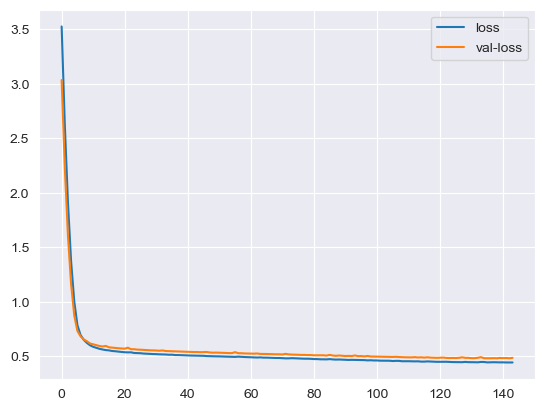

In [20]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val-loss')
plt.legend()
plt.show()

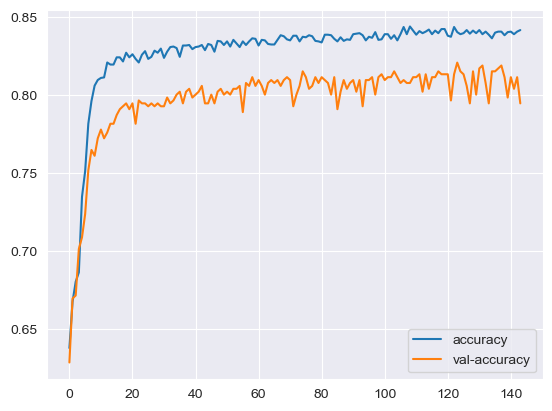

In [21]:
# Evaluate the model
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val-accuracy')
plt.legend()
plt.show()

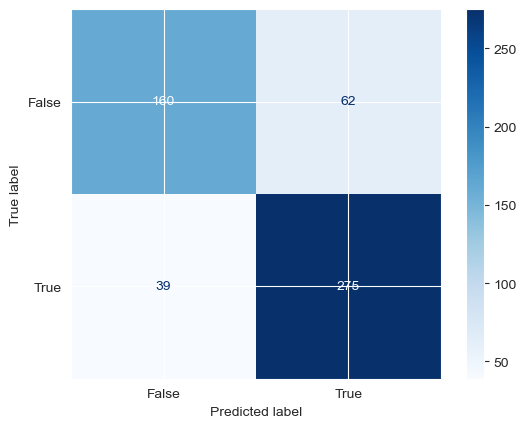

In [22]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot(cmap='Blues')
plt.show()

In [23]:
model_directory = get_config("model_directory")
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
full_model_path = os.path.join(model_directory, "nfl_features_model.keras")
model.save(full_model_path)

In [24]:
data_directory = get_config('data_directory')
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

full_path = os.path.join(data_directory, "nfl_ml_features_scaled.npz")
np.savez(full_path, X=X, y=y)

In [25]:
full_path = os.path.join(data_directory, "nfl_ml_features.parquet")
stats_df.to_parquet(full_path)